prompt:
Is there a relationship between child nutrition or health indicators (e.g., anemia) and school attendance?

In [ ]:
# ==========================================
# STEP 1: IMPORTS
# ==========================================
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, statsmodels.api as sm
from fuzzywuzzy import process
import statsmodels.api as sm
import shap
pd.options.display.float_format = '{:.2f}'.format


c:\Users\LAKSHYA\Downloads\Datathon 2025-20251106T122426Z-1-001\Datathon 2025\venv\Lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [40]:

# ==========================================
# STEP 2: LOAD DATASETS
# ==========================================
fac = pd.read_csv('UDISE Education Dataset/UDISE 2023-24/facility_data_All State_2023-24/100_fac.csv', low_memory=False)
prof1 = pd.read_csv('UDISE Education Dataset/UDISE 2023-24/profile_data_1_All State_2023-24/100_prof1.csv', low_memory=False)
enr1 = pd.read_csv('UDISE Education Dataset/UDISE 2023-24/enrolment_data_1_All State_2023-24/100_enr1.csv', low_memory=False)
nfhs_5 = pd.read_csv('UDISE Education Dataset/UDISE 2023-24/NFHS_5_India_Districts_Factsheet_Data.csv', low_memory=False)

print("✅ Datasets Loaded")
print(f"fac: {fac.shape}, prof1: {prof1.shape}, enr1: {enr1.shape}, nfhs_5: {nfhs_5.shape}")


# # Dictionary to store all dataframes
# datasets = {
#     'Facility Data (fac)': fac,
#     'Profile Data 1 (prof1)': prof1,
#     'Enrollment Data 1 (enr1)': enr1,
#     'NHFS 5 (nhfs_5)': nhfs_5
# }

# # Print metadata and columns for each dataset
# for name, df in datasets.items():
#     print(f"\n{'='*80}")
#     print(f"Dataset: {name}")
#     print(f"{'='*80}")
    
#     # Basic metadata
#     print(f"\nShape: {df.shape[0]} rows × {df.shape[1]} columns")
#     print(f"Memory Usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    
#     # Column namesa
#     print(f"\nColumn Names ({len(df.columns)} total):")
#     print("-" * 80)
#     for i, col in enumerate(df.columns, 1):
#         print(f"{i:3d}. {col}")
    
#     # Data types summary
#     print(f"\nData Types Summary:")
#     print(df.dtypes.value_counts())
    
#     # Missing values
#     missing = df.isnull().sum()
#     if missing.sum() > 0:
#         print(f"\nColumns with Missing Values:")
#         print(missing[missing > 0])
#     else:
#         print(f"\nNo missing values found.")
    
#     # Basic info
#     print(f"\nDetailed Info:")
#     print(df.info())

# print(f"\n{'='*80}")
# print("Metadata extraction complete!")
# print(f"{'='*80}")

✅ Datasets Loaded
fac: (1471891, 70), prof1: (1471891, 38), enr1: (8234734, 29), nfhs_5: (706, 109)


In [41]:
# ==========================================
# STEP 3: SELECT USEFUL COLUMNS
# ==========================================
fac_sel = fac[['pseudocode','medical_checkups','handwash_facility_for_meal',
               'playground_available','electricity_availability','library_availability','tap_yn']].copy()
prof_sel = prof1[['pseudocode','state','district','avg_instr_days']].copy()
enr_sel = enr1[['pseudocode','c1_b','c1_g','c2_b','c2_g','c3_b','c3_g',
                'c4_b','c4_g','c5_b','c5_g','c6_b','c6_g','c7_b','c7_g','c8_b','c8_g']].copy()


In [42]:
# ==========================================
# STEP 4: FEATURE ENGINEERING
# ==========================================
enr_sel['total_enrolment'] = enr_sel.drop(columns='pseudocode').sum(axis=1)
fac_sel['health_index'] = fac_sel[['medical_checkups','handwash_facility_for_meal']].mean(axis=1)
fac_sel['infra_index']  = fac_sel[['playground_available','electricity_availability',
                                   'library_availability','tap_yn']].mean(axis=1)
print("Health/Infra indices ready.")


Health/Infra indices ready.


In [43]:
# ==========================================
# STEP 5: MERGE & AGGREGATE BY DISTRICT
# ==========================================
merged = (prof_sel.merge(fac_sel,on='pseudocode',how='left')
                   .merge(enr_sel[['pseudocode','total_enrolment']],on='pseudocode',how='left'))
district_df = merged.groupby(['state','district'],as_index=False).agg(
    avg_instruction_days=('avg_instr_days','mean'),
    mean_health_index=('health_index','mean'),
    mean_infra_index=('infra_index','mean'),
    total_enrolment=('total_enrolment','sum')
)
print("UDISE aggregated districts:", district_df.shape)
print("Sample:", district_df.head(3))


UDISE aggregated districts: (788, 6)
Sample:                        state                   district  avg_instruction_days  \
0  ANDAMAN & NICOBAR ISLANDS                   ANDAMANS                216.02   
1  ANDAMAN & NICOBAR ISLANDS  MIDDLE AND NORTH ANDAMANS                217.37   
2  ANDAMAN & NICOBAR ISLANDS                   NICOBARS                216.78   

   mean_health_index  mean_infra_index  total_enrolment  
0               1.02              1.05         35716.00  
1               1.02              1.09         14180.00  
2               1.02              1.11          8626.00  


In [ ]:
# # ==========================================
# # STEP 6: CLEAN NFHS COLUMNS
# # ==========================================
# nfhs = nfhs_5.rename(columns={
#     'State/UT':'state','District Names':'district',
#     'Children age 6-59 months who are anaemic (<11.0 g/dl)22 (%)':'anemia_rate',
#     'Children under 5 years who are stunted (height-for-age)18 (%)':'stunting_rate',
#     'Children under 5 years who are underweight (weight-for-age)18 (%)':'underweight_rate'
# })[['state','district','anemia_rate','stunting_rate','underweight_rate']]
# print("NFHS cleaned:", nfhs.shape)


NFHS cleaned: (706, 5)


In [75]:
# ==========================================
# STEP 7: CLEAN & PREPARE NFHS DATA
# ==========================================
# Select and rename relevant NFHS columns, including vaccination and overweight rates
nfhs_clean = nfhs_5.rename(columns={
    'State/UT': 'state',
    'District Names': 'district',
    'Children age 6-59 months who are anaemic (<11.0 g/dl)22 (%)': 'anemia_rate',
    'Children under 5 years who are stunted (height-for-age)18 (%)': 'stunting_rate',
    'Children under 5 years who are underweight (weight-for-age)18 (%)': 'underweight_rate',
    'Children age 12-23 months fully vaccinated based on information from either vaccination card or mother\'s recall11 (%)': 'vaccination_rate',
    'Children under 5 years who are overweight (weight-for-height)20 (%)': 'overweight_rate'
})[['state', 'district', 'anemia_rate', 'stunting_rate', 'underweight_rate', 'vaccination_rate', 'overweight_rate']]

print("✅ NFHS data cleaned and subsetted")
print("NFHS shape:", nfhs_clean.shape)
print(nfhs_clean.head(3))

✅ NFHS data cleaned and subsetted
NFHS shape: (706, 7)
                       state                 district anemia_rate  \
0  Andaman & Nicobar Islands                 Nicobars       37.7    
1  Andaman & Nicobar Islands  North & Middle Andaman        30.4    
2  Andaman & Nicobar Islands           South Andaman        43.4    

  stunting_rate underweight_rate vaccination_rate overweight_rate  
0         21.6             24.6            (64.2)            1.5   
1         27.0             42.8                 *            0.8   
2         21.1             17.4            (76.3)            7.2   


In [53]:
# ==========================================
# STEP 8: FUZZY MATCH STATES & DISTRICTS
# ==========================================
from fuzzywuzzy import process

def fuzzy_match(df_source, df_target, source_col, target_col, threshold=88):
    """
    Creates a mapping between names in df_source[source_col] and df_target[target_col]
    using fuzzy matching.
    """
    mapping = {}
    for name in df_source[source_col].unique():
        match, score = process.extractOne(name, df_target[target_col].unique())
        if score >= threshold:
            mapping[name] = match
    return mapping

# Fuzzy match states first
state_map = fuzzy_match(district_df, nfhs_clean, 'state', 'state', threshold=90)
district_df['state_matched'] = district_df['state'].replace(state_map)

# Fuzzy match districts within each state
matched_frames = []
for st in district_df['state_matched'].unique():
    udise_sub = district_df[district_df['state_matched'] == st]
    nfhs_sub = nfhs_clean[nfhs_clean['state'] == st]
    if nfhs_sub.empty:
        continue
    dist_map = fuzzy_match(udise_sub, nfhs_sub, 'district', 'district', threshold=85)
    udise_sub = udise_sub.copy()
    udise_sub.loc[:, 'district_matched'] = udise_sub['district'].replace(dist_map)
    matched_frames.append(udise_sub)

district_matched = pd.concat(matched_frames, ignore_index=True)

print("✅ Fuzzy matching complete")
print("Districts matched:", district_matched['district_matched'].notna().sum(), "of", len(district_matched))
print("Example matches:")
print(district_matched[['state', 'district', 'district_matched']].sample(10, random_state=1))


✅ Fuzzy matching complete
Districts matched: 788 of 788
Example matches:
                state       district district_matched
541         RAJASTHAN          AJMER           Ajmer 
310         KARNATAKA         HASSAN          Hassan 
752       UTTARAKHAND      BAGESHWAR       Bageshwar 
516        PUDUCHERRY    PONDICHERRY      PONDICHERRY
245  HIMACHAL PRADESH          MANDI           Mandi 
661         TELANGANA     SANGAREDDY      Sangareddy 
495            ODISHA  JAGATSINGHPUR  Jagatsinghapur 
685     UTTAR PRADESH      BALRAMPUR       Balrampur 
154      CHHATTISGARH        RAIGARH         Raigarh 
233           HARYANA         REWARI          Rewari 


In [76]:
# ==========================================
# STEP 9: FINAL MERGE BETWEEN UDISE & NFHS
# ==========================================
final_df = pd.merge(
    district_matched,
    nfhs_clean,
    left_on=['state_matched', 'district_matched'],
    right_on=['state', 'district'],
    how='inner'
)

print("✅ Final merged dataset shape:", final_df.shape)
print("Columns:", list(final_df.columns))

# Rename columns for clarity
final_df.rename(columns={
    'state_matched': 'state',
    'district_matched': 'district'
}, inplace=True)

# Drop redundant duplicate columns from NFHS
final_df.drop(columns=['state_x', 'state_y'], errors='ignore', inplace=True)

# Display sample rows safely
cols_to_show = [
    'state', 'district', 'avg_instruction_days',
    'mean_health_index', 'mean_infra_index',
    'anemia_rate', 'stunting_rate', 'underweight_rate', 
    'vaccination_rate', 'overweight_rate'
]
cols_to_show = [c for c in cols_to_show if c in final_df.columns]

print("Sample merged rows:")
display(final_df[cols_to_show].head(10))


✅ Final merged dataset shape: (678, 16)
Columns: ['state_x', 'district_x', 'avg_instruction_days', 'mean_health_index', 'mean_infra_index', 'total_enrolment', 'state_std', 'state_matched', 'district_matched', 'state_y', 'district_y', 'anemia_rate', 'stunting_rate', 'underweight_rate', 'vaccination_rate', 'overweight_rate']
Sample merged rows:


,state,district,avg_instruction_days,mean_health_index,mean_infra_index,anemia_rate,stunting_rate,underweight_rate,vaccination_rate,overweight_rate
0,Andaman & Nicobar Islands,North & Middle Andaman,217.37,1.02,1.09,30.4,27.0,42.8,*,0.8
1,Andaman & Nicobar Islands,Nicobars,216.78,1.02,1.11,37.7,21.6,24.6,(64.2),1.5
2,Andhra Pradesh,Anantapur,209.75,1.04,1.06,55.8,36.0,40.6,(81.8),0.3
3,Andhra Pradesh,Chittoor,211.62,1.02,1.08,54.9,27.1,27.9,(66.6),0.5
4,Andhra Pradesh,East Godavari,209.26,1.01,1.06,66.8,23.1,22.4,(59.0),3.4
5,Andhra Pradesh,Guntur,210.32,1.02,1.07,59.3,23.8,26.9,(76.2),3.6
6,Andhra Pradesh,Krishna,209.56,1.01,1.05,65.7,29.8,21.1,(90.0),4.2
7,Andhra Pradesh,Kurnool,214.14,1.00,1.09,70.8,50.5,46.3,67.0,1.1
8,Andhra Pradesh,Prakasam,208.31,1.01,1.11,62.6,22.6,24.7,(51.9),5.1
9,Andhra Pradesh,Sri Potti Sriramulu Nello,203.37,1.04,1.10,67.5,29.2,27.8,65.3,0.5


In [77]:
# ==========================================
# STEP 10: CLEAN FINAL DATA FOR ANALYSIS
# ==========================================
# Keep only necessary numeric columns for modeling
analysis_cols = [
    'avg_instruction_days', 'mean_health_index', 'mean_infra_index',
    'anemia_rate', 'stunting_rate', 'underweight_rate', 
    'vaccination_rate', 'overweight_rate'
]

analysis_df = final_df[analysis_cols].copy()

# Drop missing or invalid values
analysis_df.replace([np.inf, -np.inf], np.nan, inplace=True)
analysis_df.dropna(inplace=True)

print("✅ Cleaned analysis dataset ready!")
print("Shape:", analysis_df.shape)
display(analysis_df.describe())
print(analysis_df.head())



# ==========================================
# FIX: CLEAN STRING FORMATTED NUMERIC COLUMNS
# ==========================================
# Define columns that should be numeric
numeric_cols = ['avg_instruction_days', 'mean_health_index', 'mean_infra_index',
                'anemia_rate', 'stunting_rate', 'underweight_rate', 
                'vaccination_rate', 'overweight_rate']

# Function to clean numeric strings like '(71.6)' or '71.6%' etc.
def clean_numeric(x):
    if isinstance(x, str):
        x = x.strip().replace('%', '').replace('(', '').replace(')', '')
    try:
        return float(x)
    except:
        return np.nan

for col in numeric_cols:
    if col in analysis_df.columns:
        analysis_df[col] = analysis_df[col].apply(clean_numeric)

# Recheck types
print("✅ Data types after cleaning:")
print(analysis_df.dtypes)

# Drop rows that are still invalid
analysis_df.dropna(inplace=True)

print("✅ Data cleaned and converted to numeric:", analysis_df.shape)
display(analysis_df.head())


✅ Cleaned analysis dataset ready!
Shape: (678, 8)


,avg_instruction_days,mean_health_index,mean_infra_index
count,678.00,678.00,678.00
mean,211.03,1.18,1.27
std,17.35,0.16,0.26
min,69.43,1.00,1.00
25%,201.03,1.05,1.11
50%,213.17,1.14,1.22
75%,223.96,1.24,1.32
max,238.58,1.90,2.99


   avg_instruction_days  mean_health_index  mean_infra_index anemia_rate  \
0                217.37               1.02              1.09       30.4    
1                216.78               1.02              1.11       37.7    
2                209.75               1.04              1.06       55.8    
3                211.62               1.02              1.08       54.9    
4                209.26               1.01              1.06       66.8    

  stunting_rate underweight_rate vaccination_rate overweight_rate  
0         27.0             42.8                 *            0.8   
1         21.6             24.6            (64.2)            1.5   
2         36.0             40.6            (81.8)            0.3   
3         27.1             27.9            (66.6)            0.5   
4         23.1             22.4            (59.0)            3.4   
✅ Data types after cleaning:
avg_instruction_days    float64
mean_health_index       float64
mean_infra_index        float64
anemia_rat

,avg_instruction_days,mean_health_index,mean_infra_index,anemia_rate,stunting_rate,underweight_rate,vaccination_rate,overweight_rate
1,216.78,1.02,1.11,37.70,21.60,24.60,64.20,1.50
2,209.75,1.04,1.06,55.80,36.00,40.60,81.80,0.30
3,211.62,1.02,1.08,54.90,27.10,27.90,66.60,0.50
4,209.26,1.01,1.06,66.80,23.10,22.40,59.00,3.40
5,210.32,1.02,1.07,59.30,23.80,26.90,76.20,3.60


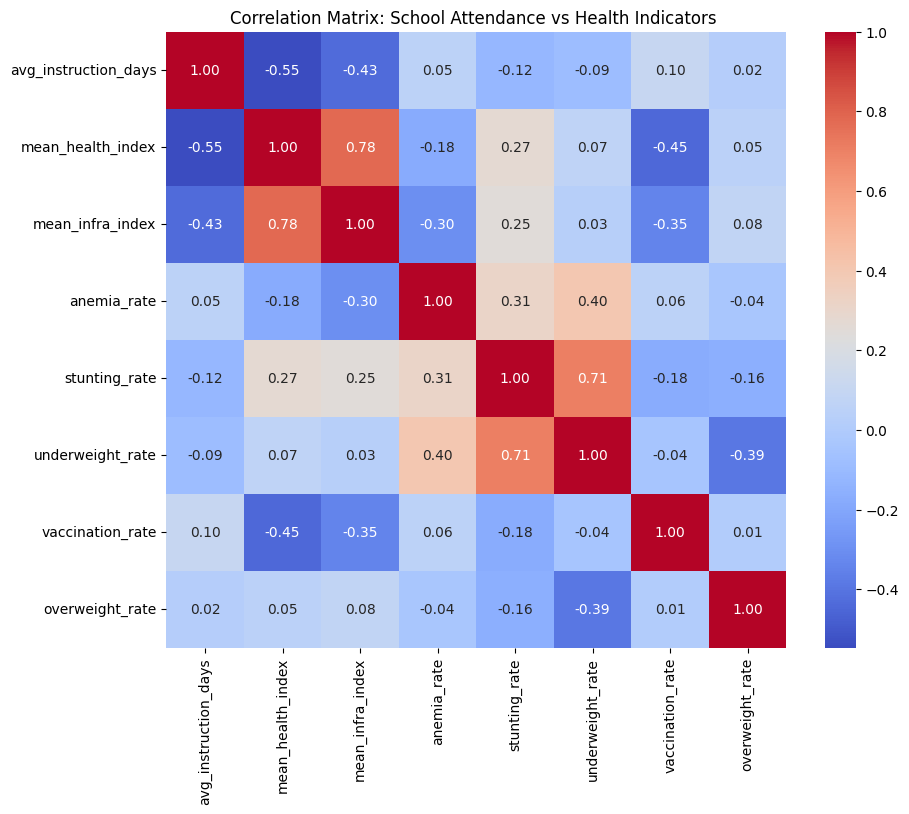

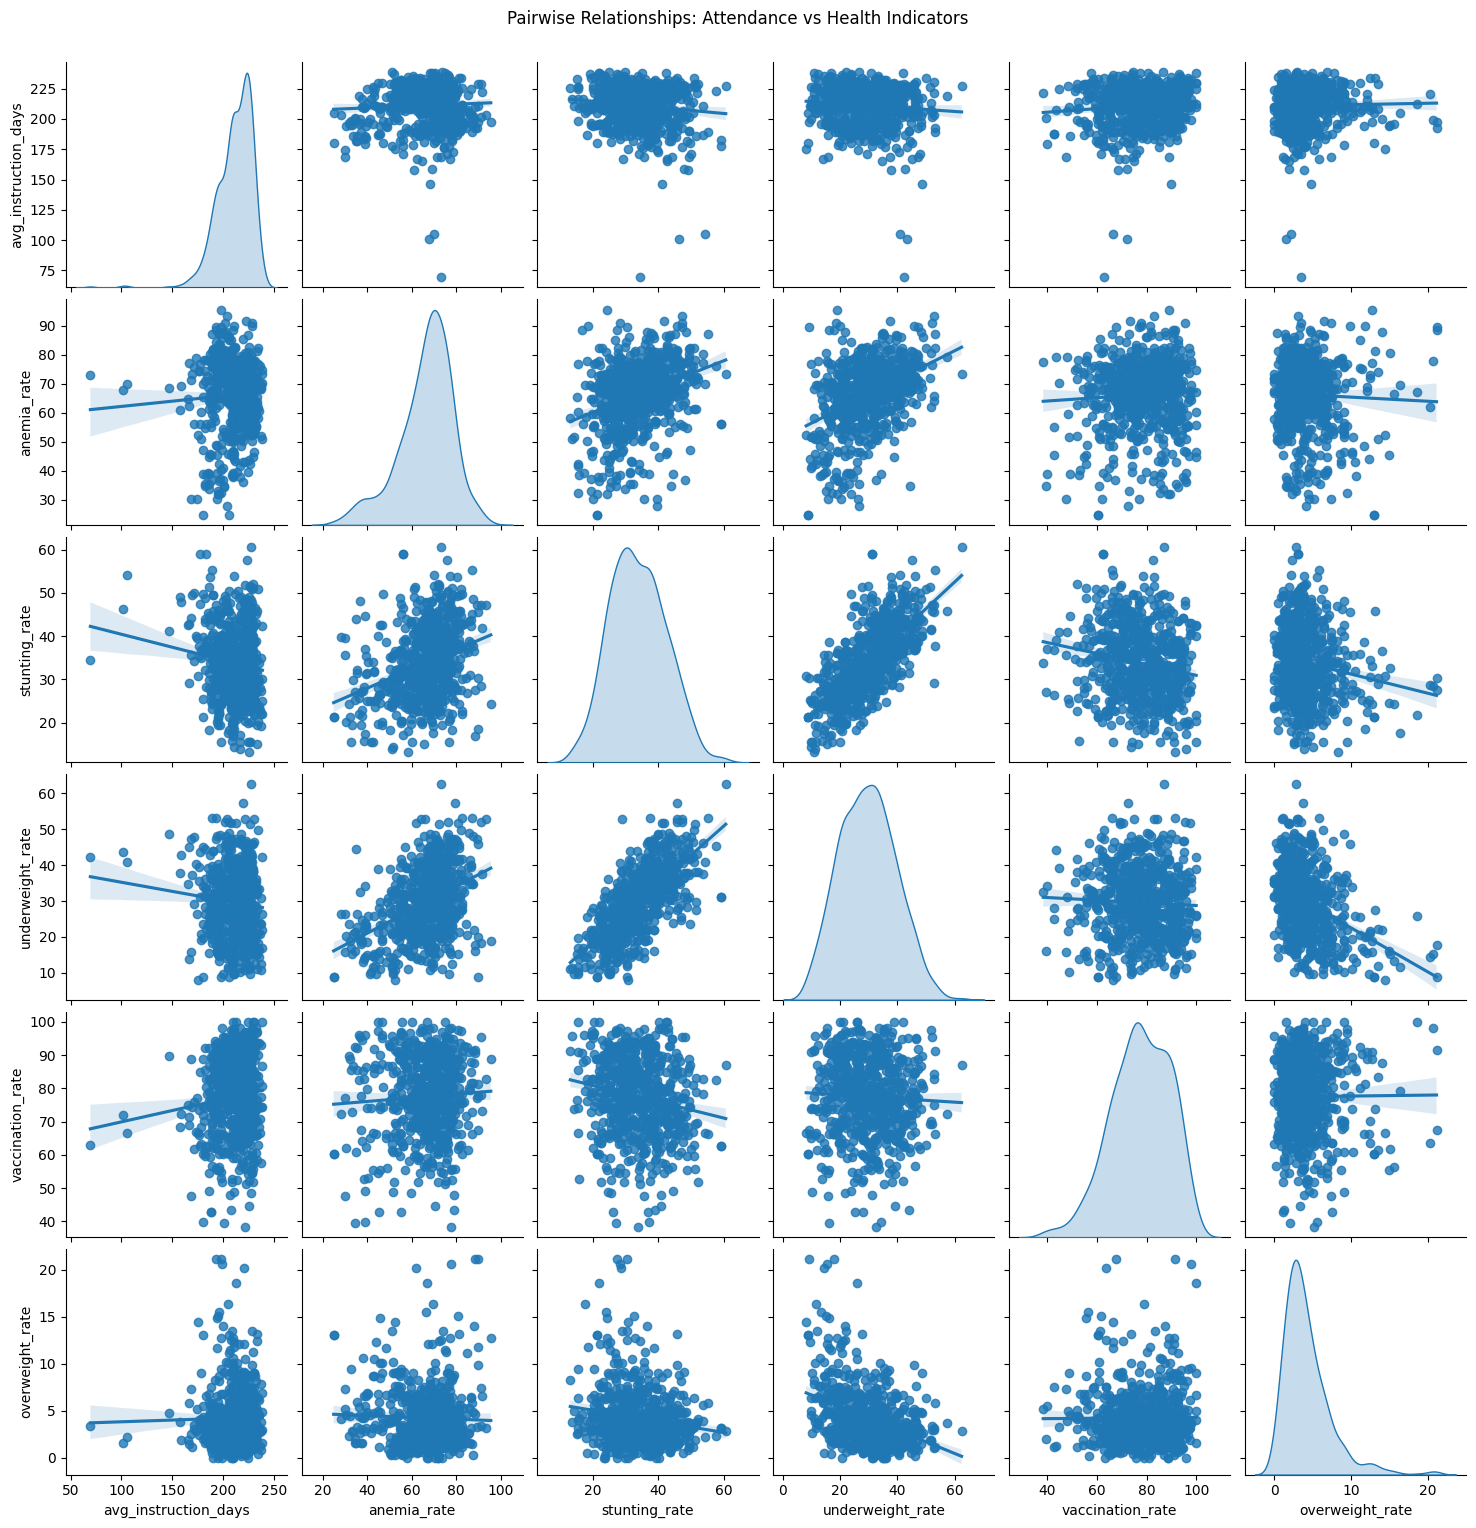

In [78]:
# ==========================================
# STEP 11: CORRELATION & VISUALIZATION
# ==========================================
plt.figure(figsize=(10,8))
sns.heatmap(analysis_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix: School Attendance vs Health Indicators ")
plt.show()

sns.pairplot(
    analysis_df,
    vars=['avg_instruction_days', 'anemia_rate', 'stunting_rate', 'underweight_rate', 
          'vaccination_rate', 'overweight_rate'],
    kind='reg', diag_kind='kde'
)
plt.suptitle("Pairwise Relationships: Attendance vs Health Indicators", y=1.02)
plt.show()

✅ Regression Summary:


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     avg_instruction_days   R-squared:                       0.338
Model:                              OLS   Adj. R-squared:                  0.331
Method:                   Least Squares   F-statistic:                     48.01
Date:                  Sat, 08 Nov 2025   Prob (F-statistic):           4.48e-55
Time:                          01:58:54   Log-Likelihood:                -2711.4
No. Observations:                   666   AIC:                             5439.
Df Residuals:                       658   BIC:                             5475.
Df Model:                             7                                         
Covariance Type:              nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               316.3178      8.305     38.087      0.000     300.010     332.626
anemia_rate          -0.0945      0.055     -1.719      0.086      -0.202       0.013
stunting_rate         0.2658      0.100      2.651      0.008       0.069       0.463
underweight_rate     -0.1915      0.092     -2.083      0.038      -0.372      -0.011
vaccination_rate     -0.2592      0.052     -4.954      0.000      -0.362      -0.156
overweight_rate       0.1845      0.200      0.924      0.356      -0.207       0.576
mean_health_index   -66.1249      5.715    -11.571      0.000     -77.346     -54.904
mean_infra_index     -3.9452      3.521     -1.120      0.263     -10.860       2.970
==============================================================================
Omnibus:                      183.212   Durbin-Watson:                   0.883
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1226.248
Skew:                          -1.049   Prob(JB):                    5.29e-267
Kurtosis:                       9.307   Cond. No.                     1.84e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.84e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

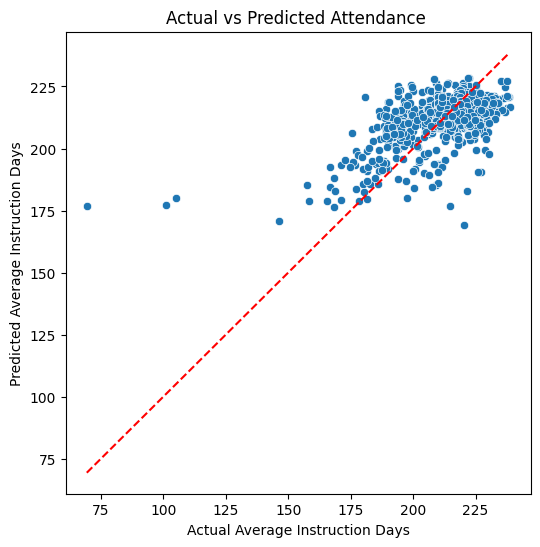

In [ ]:
# ==========================================
# STEP 12: LINEAR REGRESSION ANALYSIS
# ==========================================


# Define predictors and target
X = analysis_df[['anemia_rate', 'stunting_rate', 'underweight_rate',
                 'vaccination_rate', 'overweight_rate', 
                 'mean_health_index', 'mean_infra_index']]
y = analysis_df['avg_instruction_days']

# Add constant term
X = sm.add_constant(X)

# Fit model
model = sm.OLS(y, X).fit()

print("✅ Regression Summary:")
display(model.summary())

# Plot predicted vs actual
analysis_df['predicted_attendance'] = model.predict(X)
plt.figure(figsize=(6,6))
sns.scatterplot(x='avg_instruction_days', y='predicted_attendance', data=analysis_df)
plt.plot([analysis_df['avg_instruction_days'].min(), analysis_df['avg_instruction_days'].max()],
         [analysis_df['avg_instruction_days'].min(), analysis_df['avg_instruction_days'].max()],
         color='red', linestyle='--')
plt.xlabel("Actual Average Instruction Days")
plt.ylabel("Predicted Average Instruction Days")
plt.title("Actual vs Predicted Attendance ")
plt.show()

✅ Random Forest R²: 0.415 | RMSE: 12.00


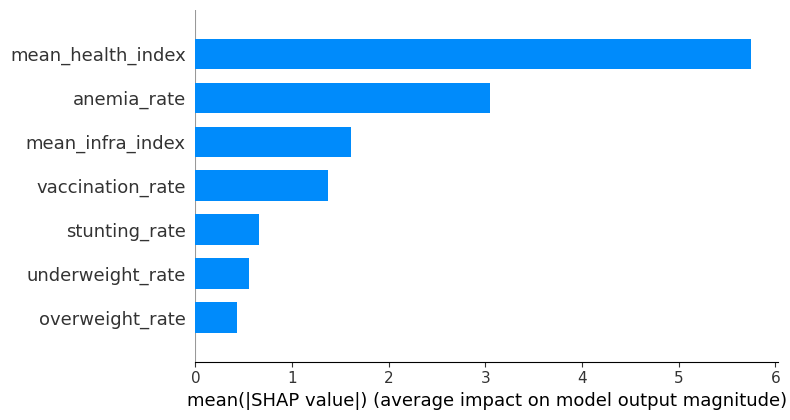

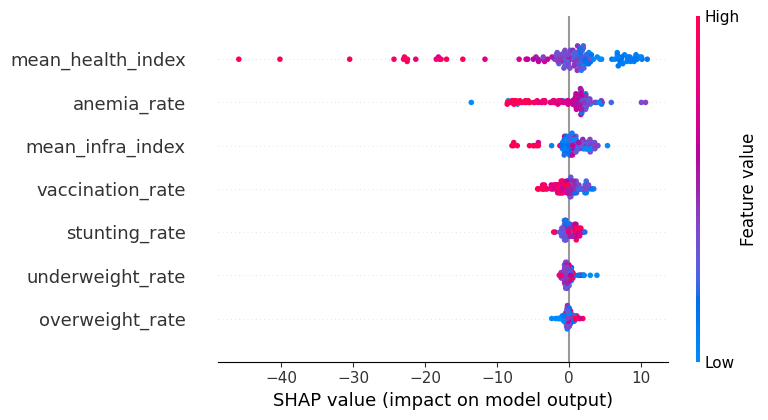

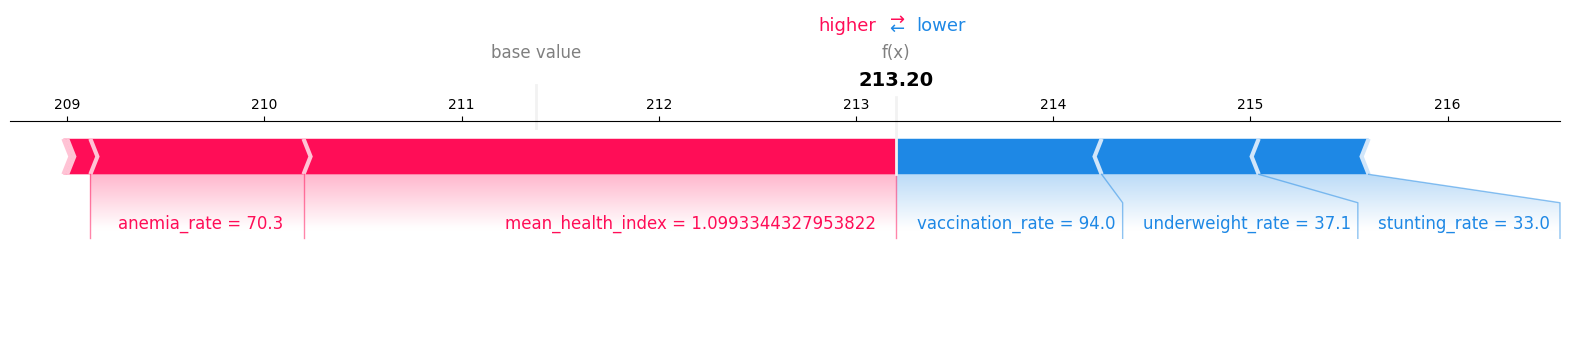

In [85]:
# ==========================================
# STEP 13: MODEL EXPLAINABILITY (SHAP ANALYSIS)
# ==========================================
import shap
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

# Split data for SHAP and model testing
X = analysis_df[['anemia_rate', 'stunting_rate', 'underweight_rate',
                 'vaccination_rate', 'overweight_rate',
                 'mean_health_index', 'mean_infra_index']]
y = analysis_df['avg_instruction_days']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest model for non-linear relationships
rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=8,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

# Evaluate model
y_pred = rf.predict(X_test)
r2 = r2_score(y_test, y_pred)

# Compute RMSE manually for compatibility
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5

print(f"✅ Random Forest R²: {r2:.3f} | RMSE: {rmse:.2f}")

# ==========================================
# SHAP Explainability
# ==========================================

# Initialize SHAP explainer
explainer = shap.Explainer(rf, X_train)
shap_values = explainer(X_test)

# Feature importance summary (bar)
shap.summary_plot(shap_values, X_test, plot_type="bar")

# Detailed summary (beeswarm)
shap.summary_plot(shap_values, X_test)

# Optional: Force plot for one prediction
sample_idx = 5
shap.initjs()
shap.force_plot(
    explainer.expected_value,
    shap_values[sample_idx].values,
    X_test.iloc[sample_idx, :],
    matplotlib=True
)
